In [1]:
%load_ext autoreload
%autoreload 2

import autograd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
from autograd import grad, value_and_grad

import legume
from legume.backend import backend as bd
from legume.optimizers import adam_optimize
from legume.utils import grad_num
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# Set some global options and parameters

options = {'gmode_inds': np.array([0, 3]),
           'gmode_compute': 'exact',
           'gradients': 'exact', 
           'verbose': False}

lattice = legume.Lattice('square')
path = lattice.bz_path(['X', 'G', 'M'], [20, 20])

eps_b = 12
gmax = 5

In [3]:
def summarize_results(gme):
    """Summarize the results of a gme run.

    Plots the bands and the real space structure
    """
    fig, ax = plt.subplots(1)
    legume.viz.bands(gme, ax=ax, Q=True, Q_cmap='cool')
    legume.viz.structure(gme)

In [4]:
# Function to make a single-layer phc with thickness d and hole radius r
def make_reg(d=0.5, r=0.3):
    """Create the gme object and build the phc with slab thickness d and hole radius r
    """
    phc = legume.PhotCryst(lattice)
    phc.add_layer(d=d, eps_b=eps_b)
    phc.add_shape(legume.Circle(eps=1, r=r))
    gme = legume.GuidedModeExp(phc, gmax=gmax)
    return gme

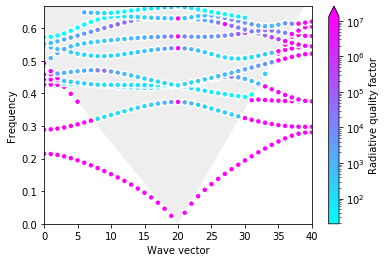

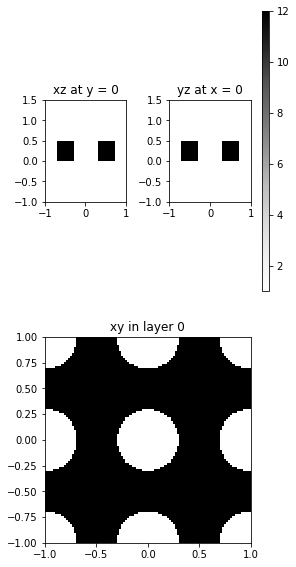

In [8]:
# Test it out
legume.set_backend('numpy')
(d0, r0) = (0.5, 0.3)
gme = make_reg(d0, r0)
gme.run(kpoints=path.kpoints, **options)
summarize_results(gme)

In [9]:
# We'll try to force a BIC at a specific k-point in the second band
kind_opt = 15
mind_opt = 1
print("Starting Q: ", gme.freqs[kind_opt, mind_opt]/2/gme.freqs_im[kind_opt, mind_opt])

Starting Q:  246.72611279764322


In [60]:
# Define objective funciton 
def objective(params):
    d = params[0]
    r = params[1]
    gme = make_reg(d, r=r)
    gme.run(kpoints=path.kpoints[:, kind_opt].reshape(2, 1), compute_im=False, numeig=240, **options)

    (freq_im, _, _) = gme.compute_rad(kind=0, minds=[mind_opt])

    # We define the of to be the log of the Q so that it doesn't vary too wildly
    return autograd.numpy.log10(gme.freqs[0, mind_opt]/2/freq_im)
#     return gme.freqs[0, mind_opt]
obj_grad = value_and_grad(objective)

In [64]:
# Check gradient vs. numerical computation
legume.set_backend('autograd')
options['eig_solver'] = 'eigh'
options['eigs_sigma'] = 0.
options['gradients'] = 'approx'
val, gr = obj_grad(np.array([d0, r0]))
print(gr)
print(grad_num(objective, np.array([d0, r0])))

[ 0.12644032 -4.29895397]
[ 0.54830304 -2.00801678]


Epoch:   1/200 | Duration: 2.49 secs | Value: 2.392215e+00 | Parameters: [ 0.5000  0.3000]
Epoch:   2/200 | Duration: 2.57 secs | Value: 2.397362e+00 | Parameters: [ 0.5020  0.2980]
Epoch:   3/200 | Duration: 2.36 secs | Value: 2.402581e+00 | Parameters: [ 0.5040  0.2960]
Epoch:   4/200 | Duration: 2.47 secs | Value: 2.407875e+00 | Parameters: [ 0.5060  0.2940]
Epoch:   5/200 | Duration: 2.42 secs | Value: 2.413247e+00 | Parameters: [ 0.5080  0.2920]
Epoch:   6/200 | Duration: 2.30 secs | Value: 2.418703e+00 | Parameters: [ 0.5100  0.2900]
Epoch:   7/200 | Duration: 2.42 secs | Value: 2.424246e+00 | Parameters: [ 0.5120  0.2880]
Epoch:   8/200 | Duration: 2.55 secs | Value: 2.429882e+00 | Parameters: [ 0.5140  0.2860]
Epoch:   9/200 | Duration: 2.38 secs | Value: 2.435615e+00 | Parameters: [ 0.5160  0.2839]
Epoch:  10/200 | Duration: 2.55 secs | Value: 2.441451e+00 | Parameters: [ 0.5180  0.2819]
Epoch:  11/200 | Duration: 2.40 secs | Value: 2.447396e+00 | Parameters: [ 0.5200  0.2799]

Epoch:  92/200 | Duration: 2.48 secs | Value: 2.894756e+00 | Parameters: [ 0.7017  0.2000]
Epoch:  93/200 | Duration: 2.64 secs | Value: 2.897472e+00 | Parameters: [ 0.7043  0.2000]
Epoch:  94/200 | Duration: 2.57 secs | Value: 2.900226e+00 | Parameters: [ 0.7068  0.2000]
Epoch:  95/200 | Duration: 2.55 secs | Value: 2.903019e+00 | Parameters: [ 0.7093  0.2000]
Epoch:  96/200 | Duration: 2.47 secs | Value: 2.905854e+00 | Parameters: [ 0.7118  0.2000]
Epoch:  97/200 | Duration: 2.60 secs | Value: 2.908732e+00 | Parameters: [ 0.7144  0.2000]
Epoch:  98/200 | Duration: 2.54 secs | Value: 2.911654e+00 | Parameters: [ 0.7170  0.2000]
Epoch:  99/200 | Duration: 2.59 secs | Value: 2.914622e+00 | Parameters: [ 0.7195  0.2000]
Epoch: 100/200 | Duration: 2.51 secs | Value: 2.917638e+00 | Parameters: [ 0.7221  0.2000]
Epoch: 101/200 | Duration: 2.38 secs | Value: 2.920705e+00 | Parameters: [ 0.7247  0.2000]
Epoch: 102/200 | Duration: 2.61 secs | Value: 2.923823e+00 | Parameters: [ 0.7273  0.2000]

Epoch: 183/200 | Duration: 2.67 secs | Value: 4.764477e+00 | Parameters: [ 0.9856  0.2085]
Epoch: 184/200 | Duration: 2.41 secs | Value: 4.728628e+00 | Parameters: [ 0.9851  0.2086]
Epoch: 185/200 | Duration: 2.69 secs | Value: 4.701055e+00 | Parameters: [ 0.9847  0.2086]
Epoch: 186/200 | Duration: 2.66 secs | Value: 4.680283e+00 | Parameters: [ 0.9843  0.2086]
Epoch: 187/200 | Duration: 2.84 secs | Value: 4.665197e+00 | Parameters: [ 0.9840  0.2085]
Epoch: 188/200 | Duration: 2.52 secs | Value: 4.654941e+00 | Parameters: [ 0.9838  0.2083]
Epoch: 189/200 | Duration: 2.33 secs | Value: 4.648843e+00 | Parameters: [ 0.9836  0.2081]
Epoch: 190/200 | Duration: 2.52 secs | Value: 4.646370e+00 | Parameters: [ 0.9835  0.2078]
Epoch: 191/200 | Duration: 2.72 secs | Value: 4.647092e+00 | Parameters: [ 0.9834  0.2074]
Epoch: 192/200 | Duration: 2.36 secs | Value: 4.650664e+00 | Parameters: [ 0.9833  0.2071]
Epoch: 193/200 | Duration: 2.60 secs | Value: 4.656805e+00 | Parameters: [ 0.9833  0.2067]

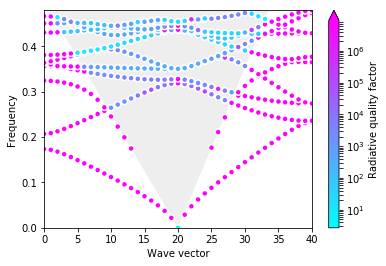

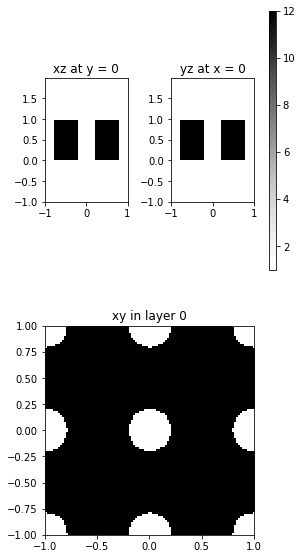

In [11]:
# options['gradients'] = 'approx' # Uncomment this to make the optimization faster using approximate gradients

# Run an optimization. We put a lower bound on the radii of 0.2 because otherwise the optimization will just
# try to make a homogeneous slab.

# The optimization is pretty unstable when it gets to very high Q. Maybe an even smaller step size is needed,
# or maybe it's just the fact that the gradient is approximate that becomes important
legume.set_backend('autograd')
t = time.time()
(p_opt, ofs) = adam_optimize(obj_grad, np.array([d0, r0]), jac=True, step_size=0.002, Nsteps=200,
                               options={'direction': 'max', 'disp': ['of', 'params']}, bounds=[0.2, 2])
print("Total time: ", time.time()-t)

legume.set_backend('numpy')
gme = make_reg(p_opt[0], p_opt[1])
gme.run(kpoints=path.kpoints, **options)
summarize_results(gme)

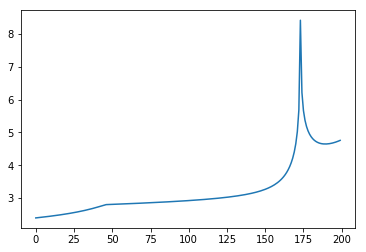

In [12]:
# Plot objective function evolution
plt.plot(ofs)
plt.show()

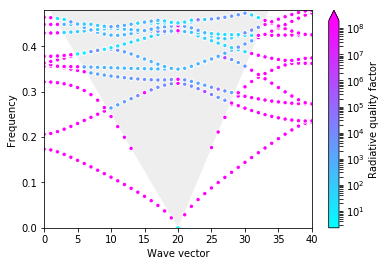

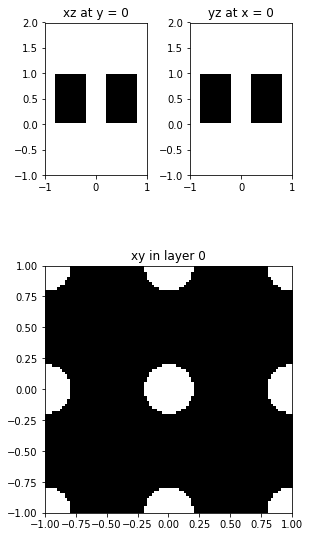

In [45]:
# Plot the best structure that was reached at the course of the optimization
# Beautiful BIC right where we wanted it!
p_max = [0.9969,  0.2010]
gme = make_reg(p_max[0], p_max[1])
gme.run(kpoints=path.kpoints, **options)
summarize_results(gme)

In [25]:
legume.set_backend('autograd')
options['gradients': 'approx']
import cProfile, pstats, io
from pstats import SortKey
pr = cProfile.Profile()
pr.enable()

(p_opt, ofs) = adam_optimize(obj_grad, np.array([d0, r0]), jac=True, step_size=0.002, Nsteps=10,
                               options={'direction': 'max', 'disp': ['of', 'params']}, bounds=[0.2, 2])

pr.disable()
s = io.StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

Epoch:   1/ 10 | Duration: 3.49 secs | Value: 2.392215e+00 | Parameters: [ 0.5000  0.3000]
Epoch:   2/ 10 | Duration: 2.93 secs | Value: 2.397362e+00 | Parameters: [ 0.5020  0.2980]
Epoch:   3/ 10 | Duration: 3.13 secs | Value: 2.402581e+00 | Parameters: [ 0.5040  0.2960]
Epoch:   4/ 10 | Duration: 2.93 secs | Value: 2.407875e+00 | Parameters: [ 0.5060  0.2940]
Epoch:   5/ 10 | Duration: 3.11 secs | Value: 2.413247e+00 | Parameters: [ 0.5080  0.2920]
Epoch:   6/ 10 | Duration: 2.87 secs | Value: 2.418703e+00 | Parameters: [ 0.5100  0.2900]
Epoch:   7/ 10 | Duration: 2.99 secs | Value: 2.424246e+00 | Parameters: [ 0.5120  0.2880]
Epoch:   8/ 10 | Duration: 3.05 secs | Value: 2.429882e+00 | Parameters: [ 0.5140  0.2860]
Epoch:   9/ 10 | Duration: 3.30 secs | Value: 2.435615e+00 | Parameters: [ 0.5160  0.2839]
Epoch:  10/ 10 | Duration: 3.20 secs | Value: 2.441451e+00 | Parameters: [ 0.5180  0.2819]
         39918943 function calls (38463751 primitive calls) in 30.229 seconds

   Ordered 